<h2> Smart meters in London </h2>

**Contexto**
- El gobierno de UK ha instalado un medidor de energía ([*smart meter*](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)) en casa cada de Escocia, Reino Unido y Gales.
- Para tener un dataset más descriptivo, se incluyen columnas relacionadas con el tiempo a partir de [Dark Sky API](https://darksky.net/dev).

**Objetivo**
- Segmentación del patrón diario de consumición mediante k-Means.

Dependencies

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

Análisis exploratorio de datos (EDA)

In [3]:
df_daily = pd.read_csv("daily_dataset.csv")
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


In [4]:
df_daily.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


- Tiene un total de 9 columnas: LCLid (ID de cada casa), day (columna temporal) y el resto son estadísticos de la energía consumida (mediana, media, máxima, valor consumido, desviación estándar, mínimo).
- Hay 2 columnas tipo objeto: *day* y *LCLid* (el resto son numéricas).
- Hay 3,510.433 instancias o filas.

In [5]:
len(df_daily.LCLid.unique())*28*30

4675440

En realidad, tenemos solo 5566 medidores donde cada medidor da un dato diario. Por eso tenemos 3510433 filas porque en realidad cada usuario brinda datos diarios desde noviembre de 2011 hasta febrero de 2014, es decir, más o menos suponiendo que cada mes tiene 30 días y son un total de 28 meses, es decir:
28x30x5566.

In [6]:
df = df_daily[df_daily.LCLid == "MAC000132"]

<AxesSubplot:>

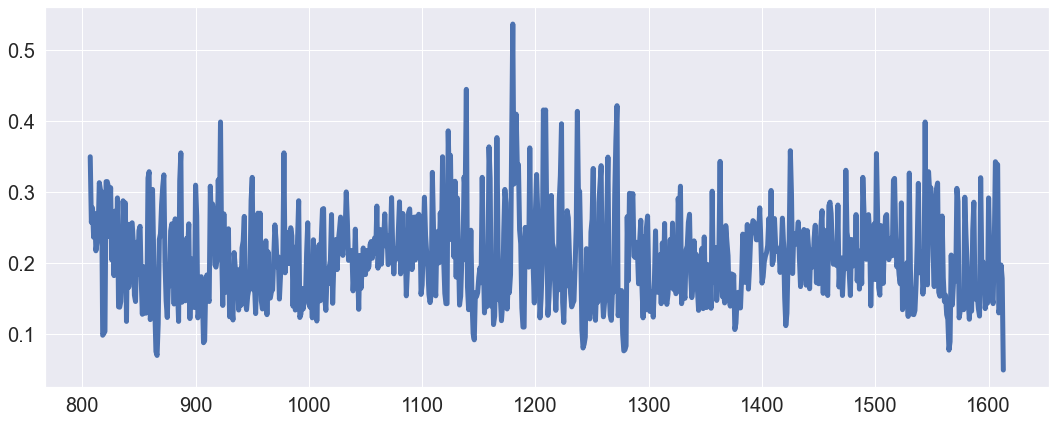

In [7]:
df['energy_median'].plot(figsize=(18,7), linewidth=5, fontsize=20)

In [8]:
len(df_daily.LCLid.unique())

5566

Probablemente no se pusieron todos los medidores el mismo día, sino que se fue realizando de manera gradual.

<AxesSubplot:xlabel='day'>

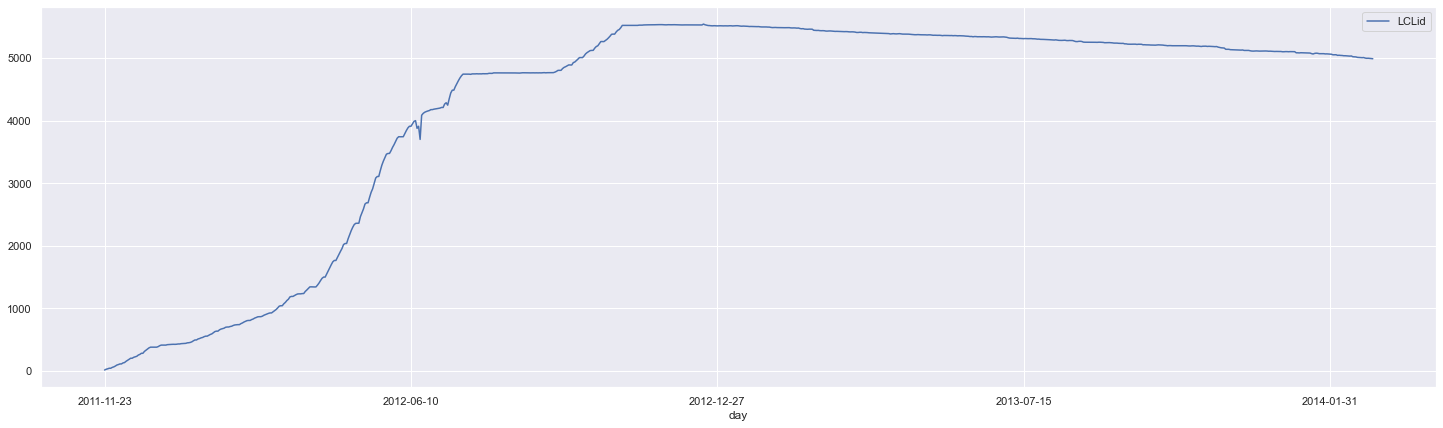

In [9]:
house_cont = df_daily.groupby('day')[['LCLid']].nunique()
house_cont.plot(figsize=(25,7))

Como se puede ver, cada día no tiene un total de 5566 medidas (una por usuario o medidor), sino que los fueron disponiendo gradualmente. Por tanto, como no es homogéneo se va a hacer ingeniería de características definiendo una nueva variable: energía consumida por usuario.

In [10]:
df_daily = df_daily[["day","LCLid","energy_sum"]]
df_daily

,day,LCLid,energy_sum
0,2011-12-15,MAC000131,9.505
1,2011-12-16,MAC000131,14.216
2,2011-12-17,MAC000131,9.111
3,2011-12-18,MAC000131,10.511
4,2011-12-19,MAC000131,15.647
...,...,...,...
3510428,2014-02-24,MAC004977,5.686
3510429,2014-02-25,MAC004977,4.042
3510430,2014-02-26,MAC004977,5.784
3510431,2014-02-27,MAC004977,5.475


In [11]:
df_daily = df_daily.groupby('day')[['energy_sum']].sum()
df_daily = df_daily.merge(house_cont, on = ['day'])
df_daily = df_daily.reset_index()

In [12]:
df_daily

,day,energy_sum,LCLid
0,2011-11-23,90.385000,13
1,2011-11-24,213.412000,25
2,2011-11-25,303.993000,32
3,2011-11-26,420.976000,41
4,2011-11-27,444.883001,41
...,...,...,...
824,2014-02-24,51994.547004,4994
825,2014-02-25,51423.508001,4995
826,2014-02-26,50943.305995,4993
827,2014-02-27,51678.185998,4990


In [13]:
df_daily.day = pd.to_datetime(df_daily.day,format='%Y-%m-%d').dt.date
df_daily['avg_energy'] =  df_daily['energy_sum']/df_daily['LCLid']

In [14]:
df_daily

,day,energy_sum,LCLid,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805
...,...,...,...,...
824,2014-02-24,51994.547004,4994,10.411403
825,2014-02-25,51423.508001,4995,10.294997
826,2014-02-26,50943.305995,4993,10.202945
827,2014-02-27,51678.185998,4990,10.356350


<AxesSubplot:xlabel='day'>

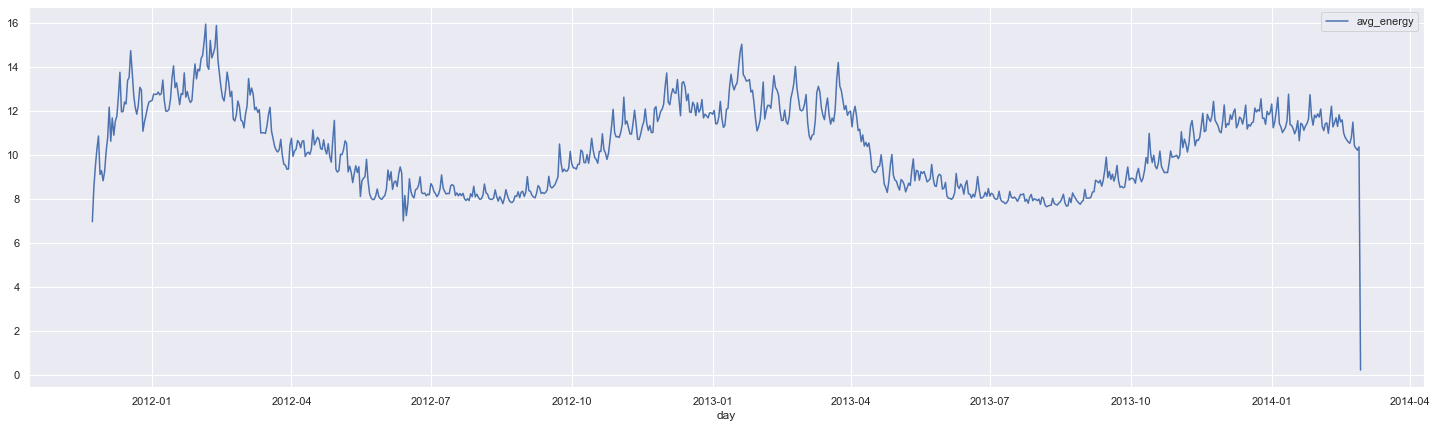

In [15]:
df_daily.plot(x="day",y="avg_energy", figsize=(25,7))

In [16]:
df_weather = pd.read_csv("weather_daily_darksky.csv")
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temperatureMax               882 non-null    float64
 1   temperatureMaxTime           882 non-null    object 
 2   windBearing                  882 non-null    int64  
 3   icon                         882 non-null    object 
 4   dewPoint                     882 non-null    float64
 5   temperatureMinTime           882 non-null    object 
 6   cloudCover                   881 non-null    float64
 7   windSpeed                    882 non-null    float64
 8   pressure                     882 non-null    float64
 9   apparentTemperatureMinTime   882 non-null    object 
 10  apparentTemperatureHigh      882 non-null    float64
 11  precipType                   882 non-null    object 
 12  visibility                   882 non-null    float64
 13  humidity            

In [17]:
df_weather.columns

Index(['temperatureMax', 'temperatureMaxTime', 'windBearing', 'icon',
       'dewPoint', 'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'time',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime',
       'moonPhase'],
      dtype='object')

In [18]:
df_weather.time

0      2011-11-11 00:00:00
1      2011-12-11 00:00:00
2      2011-12-27 00:00:00
3      2011-12-02 00:00:00
4      2011-12-24 00:00:00
              ...         
877    2014-01-26 00:00:00
878    2014-02-27 00:00:00
879    2014-03-09 00:00:00
880    2014-02-12 00:00:00
881    2014-02-15 00:00:00
Name: time, Length: 882, dtype: object

In [19]:
df_weather['day']=  pd.to_datetime(df_weather['time'])
df_weather['day']=  pd.to_datetime(df_weather['day'],format='%Y%m%d').dt.date
df_weather.date = pd.to_datetime(df_weather.day).dt.date

In [20]:
df_weather = df_weather.dropna()

In [21]:
df_weather = df_weather.drop(["time"], axis=1)

In [22]:
df_energy_weather = df_daily.merge(df_weather, on="day")
df_energy_weather.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,2011-11-23,90.385000,13,6.952692,10.36,2011-11-23 14:00:00,229,fog,6.29,2011-11-23 07:00:00,...,10.36,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,Foggy in the morning.,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94
1,2011-11-24,213.412000,25,8.536480,12.93,2011-11-24 12:00:00,204,partly-cloudy-night,8.56,2011-11-24 02:00:00,...,12.93,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,Partly cloudy throughout the day.,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97
2,2011-11-25,303.993000,32,9.499781,13.03,2011-11-25 05:00:00,243,partly-cloudy-day,7.24,2011-11-25 23:00:00,...,12.27,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,Partly cloudy throughout the day.,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01
3,2011-11-26,420.976000,41,10.267707,12.96,2011-11-26 14:00:00,237,wind,6.96,2011-11-26 01:00:00,...,12.96,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,Mostly cloudy throughout the day and breezy ov...,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05
4,2011-11-27,444.883001,41,10.850805,13.54,2011-11-27 10:00:00,256,wind,5.76,2011-11-27 23:00:00,...,13.54,2011-11-27 07:38:54,2011-11-27 10:00:00,2011-11-27 10:00:00,Breezy in the morning and partly cloudy until ...,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08


In [23]:
df_energy_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   day                          828 non-null    object 
 1   energy_sum                   828 non-null    float64
 2   LCLid                        828 non-null    int64  
 3   avg_energy                   828 non-null    float64
 4   temperatureMax               828 non-null    float64
 5   temperatureMaxTime           828 non-null    object 
 6   windBearing                  828 non-null    int64  
 7   icon                         828 non-null    object 
 8   dewPoint                     828 non-null    float64
 9   temperatureMinTime           828 non-null    object 
 10  cloudCover                   828 non-null    float64
 11  windSpeed                    828 non-null    float64
 12  pressure                     828 non-null    float64
 13  apparentTemperatureM

In [24]:
df_energy_weather.icon.unique()

array(['fog', 'partly-cloudy-night', 'partly-cloudy-day', 'wind',
       'clear-day', 'cloudy'], dtype=object)

In [25]:
df_energy_weather.precipType.unique()

array(['rain', 'snow'], dtype=object)

In [26]:
df_energy_weather['icon'] = LabelEncoder().fit_transform(df_energy_weather['icon'])
df_energy_weather['precipType'] = LabelEncoder().fit_transform(df_energy_weather['precipType'])
df_energy_weather.head(4)

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,2011-11-23 14:00:00,229,2,6.29,2011-11-23 07:00:00,...,10.36,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,Foggy in the morning.,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94
1,2011-11-24,213.412,25,8.536480,12.93,2011-11-24 12:00:00,204,4,8.56,2011-11-24 02:00:00,...,12.93,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,Partly cloudy throughout the day.,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97
2,2011-11-25,303.993,32,9.499781,13.03,2011-11-25 05:00:00,243,3,7.24,2011-11-25 23:00:00,...,12.27,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,Partly cloudy throughout the day.,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01
3,2011-11-26,420.976,41,10.267707,12.96,2011-11-26 14:00:00,237,5,6.96,2011-11-26 01:00:00,...,12.96,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,Mostly cloudy throughout the day and breezy ov...,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05


In [27]:
df_energy_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   day                          828 non-null    object 
 1   energy_sum                   828 non-null    float64
 2   LCLid                        828 non-null    int64  
 3   avg_energy                   828 non-null    float64
 4   temperatureMax               828 non-null    float64
 5   temperatureMaxTime           828 non-null    object 
 6   windBearing                  828 non-null    int64  
 7   icon                         828 non-null    int64  
 8   dewPoint                     828 non-null    float64
 9   temperatureMinTime           828 non-null    object 
 10  cloudCover                   828 non-null    float64
 11  windSpeed                    828 non-null    float64
 12  pressure                     828 non-null    float64
 13  apparentTemperatureM

In [28]:
df_energy_weather.columns

Index(['day', 'energy_sum', 'LCLid', 'avg_energy', 'temperatureMax',
       'temperatureMaxTime', 'windBearing', 'icon', 'dewPoint',
       'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime',
       'moonPhase'],
      dtype='object')

Ahora representaremos las variables meteorológicas, junto con la energía media por consumidor.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Text(0.5, 1.0, 'Energy Consumption and UV index')

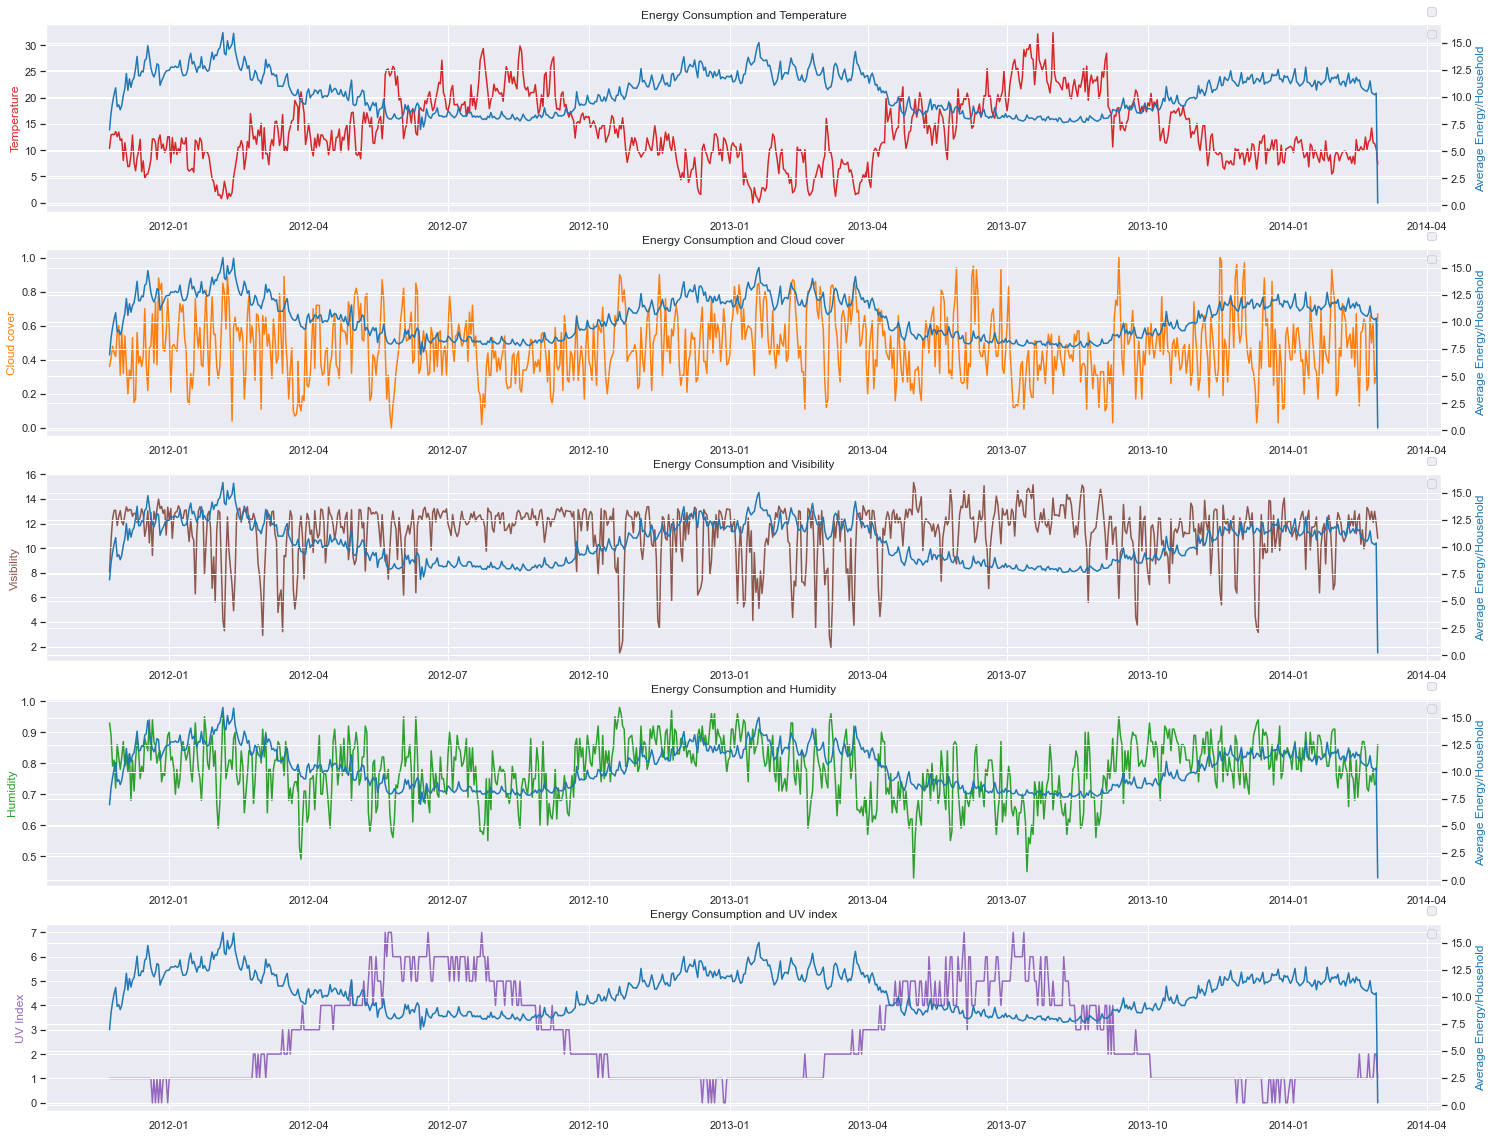

In [29]:
fig, axes = plt.subplots(5,1, figsize=(25,20))

axes[0].plot(df_energy_weather.day, df_energy_weather.temperatureMax, color = 'tab:red')
axes[0].set_ylabel('Temperature',color = 'tab:red')
axes[0].legend()
ax2 = axes[0].twinx()
ax2.plot(df_energy_weather.day,df_energy_weather.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
axes[0].set_title('Energy Consumption and Temperature')

axes[1].plot(df_energy_weather.day, df_energy_weather.cloudCover, color = 'tab:orange')
axes[1].set_ylabel('Cloud cover',color = 'tab:orange')
axes[1].legend()
ax3 = axes[1].twinx()
ax3.plot(df_energy_weather.day,df_energy_weather.avg_energy,color = 'tab:blue')
ax3.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax3.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
axes[1].set_title('Energy Consumption and Cloud cover')

axes[2].plot(df_energy_weather.day, df_energy_weather.visibility, color = 'tab:brown')
axes[2].set_ylabel('Visibility',color = 'tab:brown')
axes[2].legend()
ax4 = axes[2].twinx()
ax4.plot(df_energy_weather.day,df_energy_weather.avg_energy,color = 'tab:blue')
ax4.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax4.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
axes[2].set_title('Energy Consumption and Visibility')

axes[3].plot(df_energy_weather.day, df_energy_weather.humidity, color = 'tab:green')
axes[3].set_ylabel('Humidity',color = 'tab:green')
axes[3].legend()
ax5 = axes[3].twinx()
ax5.plot(df_energy_weather.day,df_energy_weather.avg_energy,color = 'tab:blue')
ax5.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax5.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
axes[3].set_title('Energy Consumption and Humidity')

axes[4].plot(df_energy_weather.day, df_energy_weather.uvIndex, color = 'tab:purple')
axes[4].set_ylabel('UV Index',color = 'tab:purple')
axes[4].legend()
ax6 = axes[4].twinx()
ax6.plot(df_energy_weather.day,df_energy_weather.avg_energy,color = 'tab:blue')
ax6.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax6.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
axes[4].set_title('Energy Consumption and UV index')

**Conclusiones visuales**

- Cuanto menor es la temperatura, mayor es el consumo medio por cuidadano.
- La humedad  y las nubes, siguen la tendencia del consumo medio energético por usuario.
- A menor visibilidad, mayor consumo energético.
- Menor índice UV, mayor consumo energético.

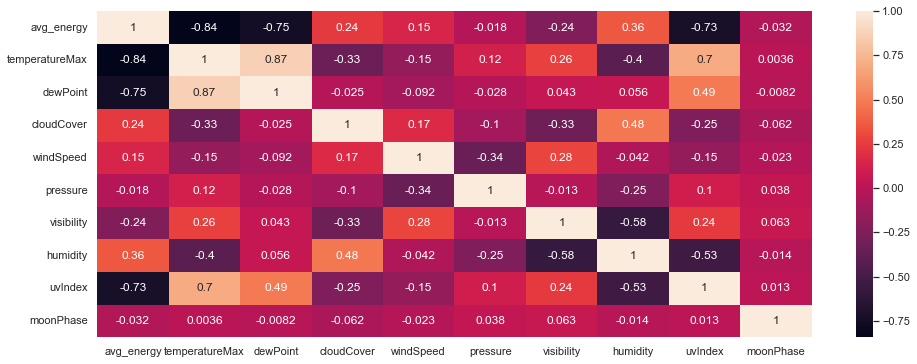

In [30]:
plt.figure(figsize=(16, 6))
cor_matrix = sns.heatmap(df_energy_weather[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr(), annot=True)

**Conclusiones matriz de correlación**

- Las características que más se relacionan con nuestra variable objetivo son: máximo de temperatura (relación inversa), dewPoint (relación inversa) y uvindex (relación inversa).

- Las características que se relacionan entre sí (redundantes) son: visibilidad vs. humedad (relación inversa) y uvindex vs. humedad (relación inversa). Como la correlación no es inferior a -0.75 o superior a 0.75, se mantendrán en el dataset.

In [31]:
df_holliday = pd.read_csv("uk_bank_holidays.csv")
df_holliday.info()
df_holliday.rename(columns={"Bank holidays":"day"})
df_holliday.columns = ["day","Type"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Bank holidays  25 non-null     object
 1   Type           25 non-null     object
dtypes: object(2)
memory usage: 528.0+ bytes


In [32]:
df_holliday['day'] = pd.to_datetime(df_holliday['day'],format='%Y-%m-%d').dt.date
df_energy_weather_holliday = df_energy_weather.merge(df_holliday, left_on = 'day',right_on = 'day',how = 'left')
df_energy_weather_holliday['Isholiday'] = np.where(df_energy_weather_holliday['Type'].isna(),0,1)
df_energy_weather_holliday = df_energy_weather_holliday.drop(["Type"], axis=1)

In [33]:
df_energy_weather_holliday.Isholiday.unique()

array([0, 1])

<AxesSubplot:xlabel='day', ylabel='avg_energy'>

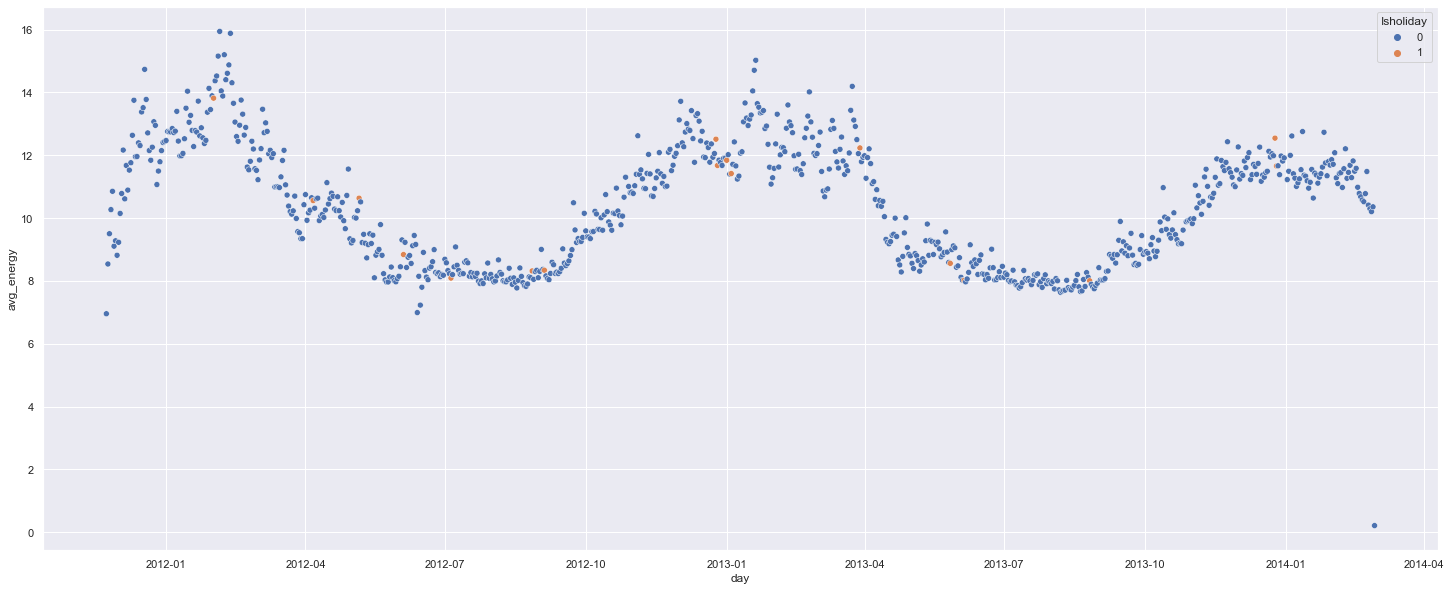

In [34]:
plt.figure(figsize=(25, 10))
sns.scatterplot(data=df_energy_weather_holliday, x="day",y="avg_energy", hue="Isholiday")

In [35]:
df_energy_weather_holliday.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,...,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Isholiday
0,2011-11-23,90.385000,13,6.952692,10.36,2011-11-23 14:00:00,229,2,6.29,2011-11-23 07:00:00,...,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,Foggy in the morning.,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94,0
1,2011-11-24,213.412000,25,8.536480,12.93,2011-11-24 12:00:00,204,4,8.56,2011-11-24 02:00:00,...,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,Partly cloudy throughout the day.,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97,0
2,2011-11-25,303.993000,32,9.499781,13.03,2011-11-25 05:00:00,243,3,7.24,2011-11-25 23:00:00,...,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,Partly cloudy throughout the day.,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01,0
3,2011-11-26,420.976000,41,10.267707,12.96,2011-11-26 14:00:00,237,5,6.96,2011-11-26 01:00:00,...,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,Mostly cloudy throughout the day and breezy ov...,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05,0
4,2011-11-27,444.883001,41,10.850805,13.54,2011-11-27 10:00:00,256,5,5.76,2011-11-27 23:00:00,...,2011-11-27 07:38:54,2011-11-27 10:00:00,2011-11-27 10:00:00,Breezy in the morning and partly cloudy until ...,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08,0


In [36]:
df_energy_weather_holliday.columns

Index(['day', 'energy_sum', 'LCLid', 'avg_energy', 'temperatureMax',
       'temperatureMaxTime', 'windBearing', 'icon', 'dewPoint',
       'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'moonPhase',
       'Isholiday'],
      dtype='object')

In [37]:
df_energy_weather_holliday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   day                          828 non-null    object 
 1   energy_sum                   828 non-null    float64
 2   LCLid                        828 non-null    int64  
 3   avg_energy                   828 non-null    float64
 4   temperatureMax               828 non-null    float64
 5   temperatureMaxTime           828 non-null    object 
 6   windBearing                  828 non-null    int64  
 7   icon                         828 non-null    int64  
 8   dewPoint                     828 non-null    float64
 9   temperatureMinTime           828 non-null    object 
 10  cloudCover                   828 non-null    float64
 11  windSpeed                    828 non-null    float64
 12  pressure                     828 non-null    float64
 13  apparentTemperatureM

In [38]:
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(df_energy_weather_holliday[['temperatureMax','humidity','windSpeed', 'windBearing', 'icon', 'dewPoint',
                                                                 'cloudCover', 'pressure','apparentTemperatureHigh', 'precipType', 'visibility', 
                                                                 'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'moonPhase', 
                                                                 'temperatureLow', 'temperatureMin', 'temperatureHigh','apparentTemperatureMin']])

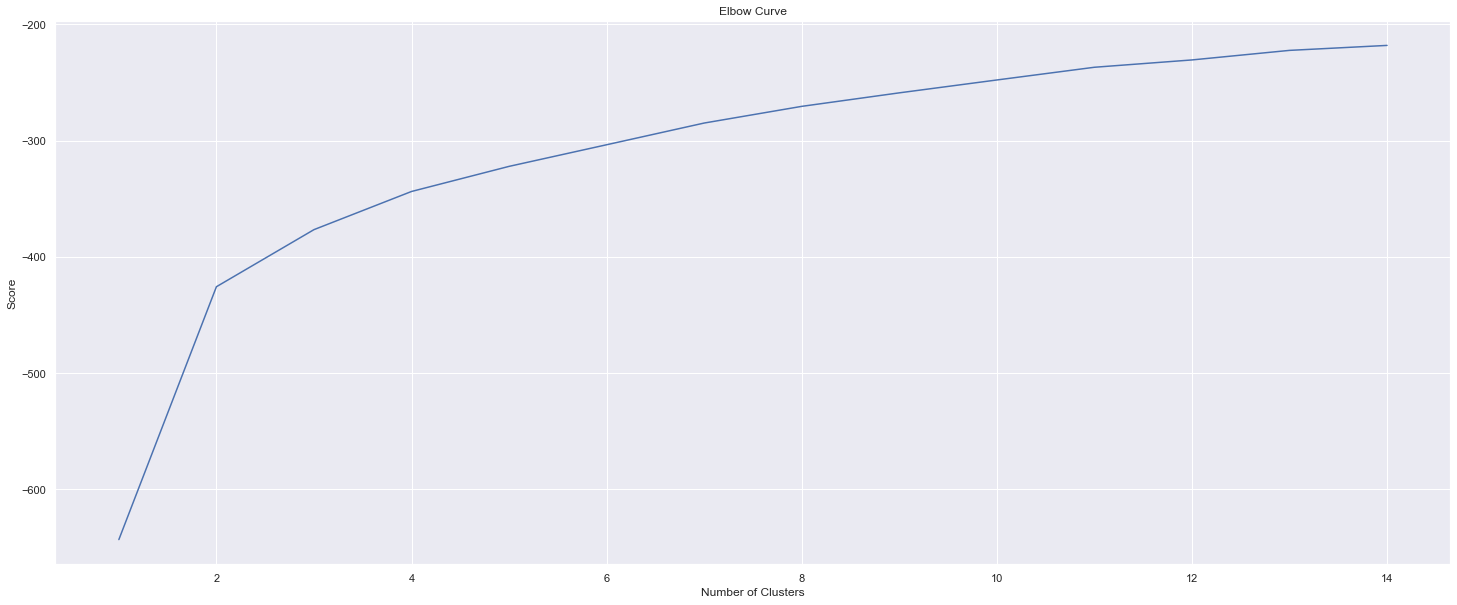

In [39]:
kmeans = [KMeans(n_clusters=i) for i in range(1, 15)]
score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
plt.figure(figsize=(25, 10))
plt.plot(range(1, 15),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [40]:
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto', random_state=50)
kmeans.fit(weather_scaled)
df_energy_weather_holliday['weather_cluster'] = kmeans.labels_

In [41]:
df_energy_weather_holliday['weather_cluster'].unique()

array([1, 0, 3, 2], dtype=int32)

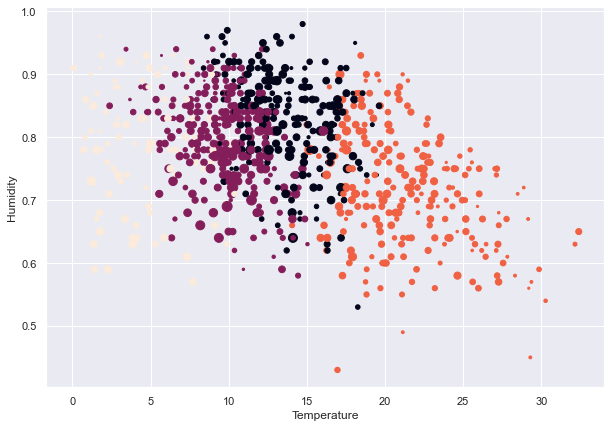

In [42]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(df_energy_weather_holliday.temperatureMax, 
            df_energy_weather_holliday.humidity, 
            s = df_energy_weather_holliday.windSpeed*10,
            c = df_energy_weather_holliday.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

## Series Temporales

Comparativa de 4 modelos para series temporales: Prophet, ARIMAX, Random Forest y LSTM.

In [43]:
# Para SARIMAX la columna temporal tiene que venir en el índice con un formato: year-month-day
df_energy_weather_holliday['Year'] = pd.DatetimeIndex(df_energy_weather_holliday['day']).year  
df_energy_weather_holliday['Month'] = pd.DatetimeIndex(df_energy_weather_holliday['day']).month
df_energy_weather_holliday.set_index(['day'],inplace=True)

In [44]:
df_energy_weather_holliday

,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,...,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Isholiday,weather_cluster,Year,Month
day,,,,,,,,,,,,,,,,,,,,,
2011-11-23,90.385000,13,6.952692,10.36,2011-11-23 14:00:00,229,2,6.29,2011-11-23 07:00:00,0.36,...,Foggy in the morning.,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94,0,1,2011,11
2011-11-24,213.412000,25,8.536480,12.93,2011-11-24 12:00:00,204,4,8.56,2011-11-24 02:00:00,0.41,...,Partly cloudy throughout the day.,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97,0,0,2011,11
2011-11-25,303.993000,32,9.499781,13.03,2011-11-25 05:00:00,243,3,7.24,2011-11-25 23:00:00,0.48,...,Partly cloudy throughout the day.,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01,0,0,2011,11
2011-11-26,420.976000,41,10.267707,12.96,2011-11-26 14:00:00,237,5,6.96,2011-11-26 01:00:00,0.44,...,Mostly cloudy throughout the day and breezy ov...,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05,0,0,2011,11
2011-11-27,444.883001,41,10.850805,13.54,2011-11-27 10:00:00,256,5,5.76,2011-11-27 23:00:00,0.42,...,Breezy in the morning and partly cloudy until ...,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08,0,1,2011,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-24,51994.547004,4994,10.411403,14.23,2014-02-24 13:00:00,183,5,6.03,2014-02-24 07:00:00,0.50,...,Mostly cloudy until evening and breezy overnight.,2014-02-25 03:00:00,5.52,2014-02-24 13:00:00,2014-02-25 03:00:00,0.82,0,1,2014,2
2014-02-25,51423.508001,4995,10.294997,11.43,2014-02-25 00:00:00,202,3,5.06,2014-02-25 21:00:00,0.62,...,Mostly cloudy throughout the day.,2014-02-26 07:00:00,3.89,2014-02-25 00:00:00,2014-02-26 07:00:00,0.86,0,1,2014,2
2014-02-26,50943.305995,4993,10.202945,11.29,2014-02-26 13:00:00,227,3,2.74,2014-02-26 07:00:00,0.26,...,Partly cloudy throughout the day.,2014-02-27 00:00:00,1.67,2014-02-26 13:00:00,2014-02-27 00:00:00,0.90,0,1,2014,2


In [45]:
# Columna weather_cluster es una columna categórica con 4 categorias obtenidas con k-Means.
df_energy_weather_holliday.columns

Index(['energy_sum', 'LCLid', 'avg_energy', 'temperatureMax',
       'temperatureMaxTime', 'windBearing', 'icon', 'dewPoint',
       'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'moonPhase',
       'Isholiday', 'weather_cluster', 'Year', 'Month'],
      dtype='object')

In [319]:
df_modelos = df_energy_weather_holliday[['energy_sum', 'LCLid', 'avg_energy', 'weather_cluster', 'Isholiday']]

In [320]:
df_modelos

,energy_sum,LCLid,avg_energy,weather_cluster,Isholiday
day,,,,,
2011-11-23,90.385000,13,6.952692,1,0
2011-11-24,213.412000,25,8.536480,0,0
2011-11-25,303.993000,32,9.499781,0,0
2011-11-26,420.976000,41,10.267707,0,0
2011-11-27,444.883001,41,10.850805,1,0
...,...,...,...,...,...
2014-02-24,51994.547004,4994,10.411403,1,0
2014-02-25,51423.508001,4995,10.294997,1,0
2014-02-26,50943.305995,4993,10.202945,1,0


# Analisis Serie Temporal

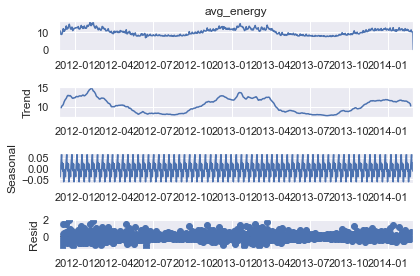

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_modelos['avg_energy'], period=12, model='additive')
decomposition.plot()
plt.show();

In [83]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_modelos['avg_energy'])
print(result[0])
print(result[1])

-1.7529035736567908
0.4040814901345803


## Train-Test

In [321]:
df_modelos = df_modelos.reset_index()

In [322]:
df_modelos['day'] = pd.to_datetime(df_modelos['day'], format='%Y-%m-%d')
df_modelos = df_modelos.set_index('day')
df_modelos = df_modelos[:827]

In [323]:
train_data, test_data = train_test_split(df_modelos, shuffle=False)

<AxesSubplot:xlabel='day'>

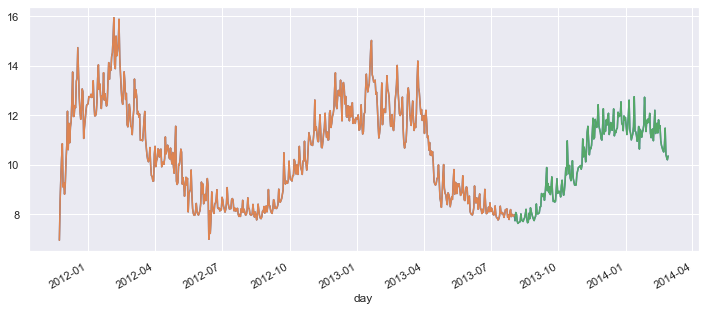

In [324]:
df_modelos.avg_energy.plot(figsize=(12,5))
train_data.avg_energy.plot()
test_data.avg_energy.plot()

In [325]:
df_modelos

,energy_sum,LCLid,avg_energy,weather_cluster,Isholiday
day,,,,,
2011-11-23,90.385000,13,6.952692,1,0
2011-11-24,213.412000,25,8.536480,0,0
2011-11-25,303.993000,32,9.499781,0,0
2011-11-26,420.976000,41,10.267707,0,0
2011-11-27,444.883001,41,10.850805,1,0
...,...,...,...,...,...
2014-02-23,57379.092995,4998,11.480411,1,0
2014-02-24,51994.547004,4994,10.411403,1,0
2014-02-25,51423.508001,4995,10.294997,1,0


# Prophet

In [326]:
df_prophet = df_modelos.reset_index()
df_prophet.drop(columns=('energy_sum'), inplace=True)
df_prophet

,day,LCLid,avg_energy,weather_cluster,Isholiday
0,2011-11-23,13,6.952692,1,0
1,2011-11-24,25,8.536480,0,0
2,2011-11-25,32,9.499781,0,0
3,2011-11-26,41,10.267707,0,0
4,2011-11-27,41,10.850805,1,0
...,...,...,...,...,...
822,2014-02-23,4998,11.480411,1,0
823,2014-02-24,4994,10.411403,1,0
824,2014-02-25,4995,10.294997,1,0
825,2014-02-26,4993,10.202945,1,0


In [327]:
df_prophet = df_prophet.rename(columns={'day' : 'ds',
                                        'avg_energy' : 'y'})
df_prophet['y'] = np.log(df_prophet['y'])
df_prophet

,ds,LCLid,y,weather_cluster,Isholiday
0,2011-11-23,13,1.939129,1,0
1,2011-11-24,25,2.144349,0,0
2,2011-11-25,32,2.251269,0,0
3,2011-11-26,41,2.329004,0,0
4,2011-11-27,41,2.384239,1,0
...,...,...,...,...,...
822,2014-02-23,4998,2.440642,1,0
823,2014-02-24,4994,2.342902,1,0
824,2014-02-25,4995,2.331658,1,0
825,2014-02-26,4993,2.322676,1,0


In [328]:
holidays = pd.DataFrame({
    'holiday' : 'holiday',
    'ds' : pd.to_datetime(['2012-02-01', '2012-04-06', '2012-05-06', '2012-06-04',
                           '2012-07-05', '2012-08-27', '2012-09-04', '2012-12-25',
                           '2012-12-26', '2013-01-01', '2013-01-04', '2013-03-29',
                           '2013-05-27', '2013-06-05', '2013-08-26', '2013-12-25',
                           '2013-12-26'])
})

In [329]:
train_data, test_data = train_test_split(df_prophet, shuffle=False)

In [330]:
prophet = Prophet(holidays = holidays)

prophet.add_regressor('weather_cluster')
prophet.add_regressor('LCLid')

prophet.add_seasonality(name='yearly', period=365, fourier_order=10)

prophet.fit(train_data)

df_cv = cross_validation(prophet, initial='365 days', period='100 days', horizon='206 days')
df_p = performance_metrics(df_cv)

print(df_p)

14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing


     horizon       mse      rmse       mae      mape     mdape     smape  \
0    20 days  0.018941  0.137626  0.129913  0.050049  0.056457  0.051483   
1    21 days  0.019092  0.138173  0.131586  0.050725  0.056457  0.052172   
2    22 days  0.018712  0.136790  0.127948  0.049276  0.056457  0.050692   
3    23 days  0.018397  0.135634  0.125351  0.048255  0.056457  0.049645   
4    24 days  0.018062  0.134395  0.123245  0.047491  0.056457  0.048857   
..       ...       ...       ...       ...       ...       ...       ...   
182 202 days  1.665470  1.290531  1.290026  0.620132  0.622701  0.899288   
183 203 days  1.678298  1.295491  1.294979  0.622234  0.627888  0.903739   
184 204 days  1.693563  1.301370  1.300867  0.624723  0.629724  0.909033   
185 205 days  1.706972  1.306511  1.306044  0.627045  0.630026  0.913968   
186 206 days  1.721683  1.312129  1.311737  0.629713  0.631557  0.919596   

     coverage  
0        0.05  
1        0.00  
2        0.05  
3        0.10  
4      

In [331]:
test_data['ds'] = pd.to_datetime(test_data['ds'])
test_y = test_data.y
test_y
test_data = test_data.drop(columns=('y'))

In [332]:
forecast = prophet.predict(test_data)

In [333]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
197,2014-02-18,2.482251,2.329809,2.619397
198,2014-02-19,2.467335,2.315971,2.610414
199,2014-02-20,2.468263,2.309090,2.608780
200,2014-02-21,2.473087,2.311471,2.622722
201,2014-02-22,2.497861,2.344599,2.647858
202,2014-02-23,2.540423,2.370573,2.688300
203,2014-02-24,2.481217,2.321029,2.626918
204,2014-02-25,2.465153,2.299272,2.619326
205,2014-02-26,2.449619,2.297063,2.603423
206,2014-02-27,2.449745,2.285686,2.592510


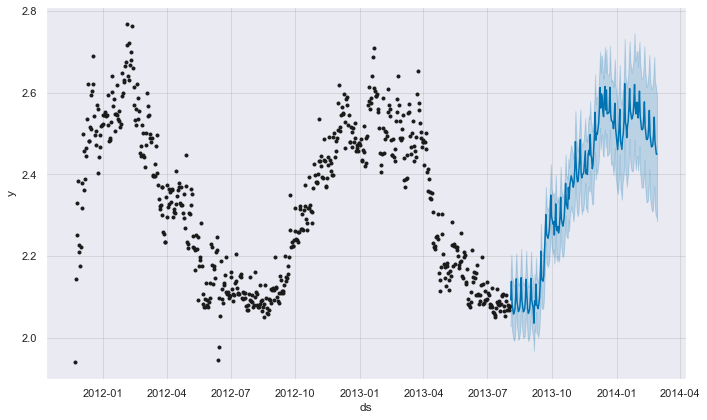

In [334]:
prophet.plot(forecast);

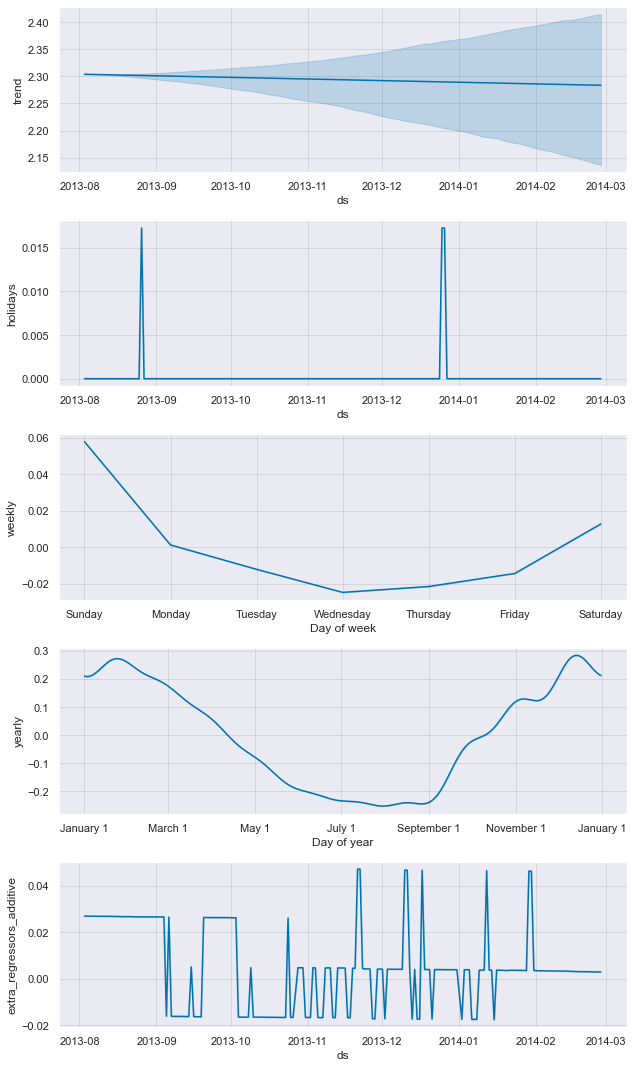

In [335]:
prophet.plot_components(forecast);

In [336]:
test_data['forecast'] = forecast.yhat.values

In [337]:
test_data['real'] = test_y
test_data['real'] = np.exp(test_data['real'])
test_data['forecast'] = np.exp(test_data['forecast'])
test_data

,ds,LCLid,weather_cluster,Isholiday,forecast,real
620,2013-08-03,5288,2,0,8.103690,7.741152
621,2013-08-04,5286,2,0,8.481399,8.073184
622,2013-08-05,5289,2,0,8.020055,8.000884
623,2013-08-06,5285,2,0,7.919452,7.714011
624,2013-08-07,5281,2,0,7.826537,7.633054
...,...,...,...,...,...,...
822,2014-02-23,4998,1,0,12.685036,11.480411
823,2014-02-24,4994,1,0,11.955808,10.411403
824,2014-02-25,4995,1,0,11.765284,10.294997
825,2014-02-26,4993,1,0,11.583933,10.202945


<AxesSubplot:>

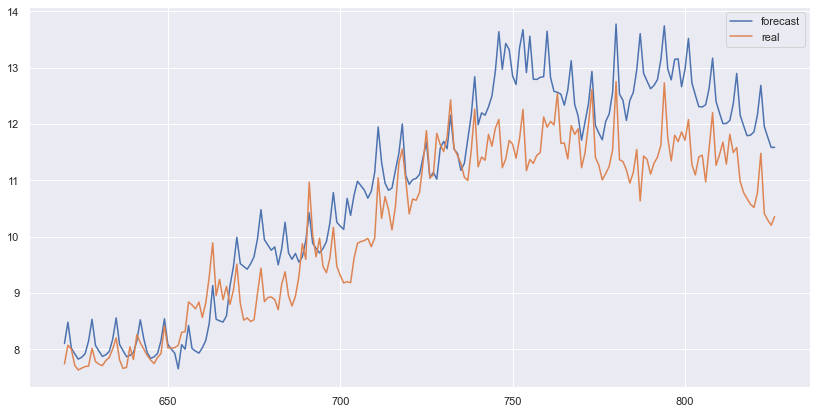

In [338]:
test_data[['forecast', 'real']].plot(figsize=(14,7))

In [318]:
rmse = np.sqrt(mean_squared_error(test_data['real'], test_data['forecast']))
print('RMSE: ', rmse)

RMSE:  0.9102664103868903


## Random Forest

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_modelos.drop(columns = "avg_energy"),
                                        df_modelos['avg_energy'],
                                        shuffle=False)

modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)

modelo.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_features='auto', n_estimators=10,
                      n_jobs=-1, random_state=123)

In [84]:
predicciones = modelo.predict(X = X_test)

mse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {np.sqrt(mse)}")

El error (mse) de test es: 0.533356226127915
El error (rmse) de test es: 0.7303124167970274


In [85]:
from sklearn.model_selection import RepeatedKFold
import multiprocessing
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True)

grid.fit(X = X_train, y = y_train)

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
0,None,5,150,-0.397270,0.086202,-0.148222,0.011571
1,None,7,150,-0.397270,0.086202,-0.148222,0.011571
2,None,9,150,-0.397270,0.086202,-0.148222,0.011571
9,20,5,150,-0.397281,0.086198,-0.148222,0.011571


In [86]:

print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': None, 'max_features': 5, 'n_estimators': 150} : -0.397269815510078 neg_root_mean_squared_error


In [87]:
modelo1 = RandomForestRegressor(
            n_estimators = 150,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 5,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

modelo1.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_features=5, n_estimators=150,
                      n_jobs=-1, random_state=123)

In [88]:
predicciones = modelo1.predict(X = X_test)

mse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {np.sqrt(mse)}")

El error (mse) de test es: 0.5692160109815979
El error (rmse) de test es: 0.7544640554602968


In [89]:
X_test['prediction'] = predicciones

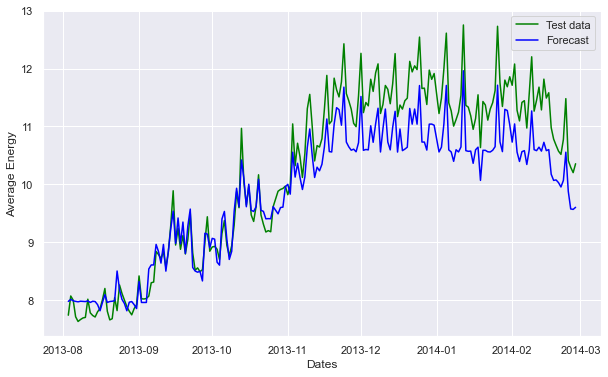

In [90]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Average Energy')
plt.plot(y_test, 'green', label='Test data')
plt.plot(X_test.prediction, 'blue', label='Forecast')
plt.legend()

## LSTM

In [66]:
df_modelos

,energy_sum,LCLid,avg_energy,weather_cluster,Isholiday
day,,,,,
2011-11-23,90.385000,13,6.952692,1,0
2011-11-24,213.412000,25,8.536480,1,0
2011-11-25,303.993000,32,9.499781,0,0
2011-11-26,420.976000,41,10.267707,0,0
2011-11-27,444.883001,41,10.850805,0,0
...,...,...,...,...,...
2014-02-23,57379.092995,4998,11.480411,0,0
2014-02-24,51994.547004,4994,10.411403,1,0
2014-02-25,51423.508001,4995,10.294997,1,0


In [67]:
cols = df_modelos[['avg_energy', 'LCLid', 'weather_cluster', 'Isholiday']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(cols)

In [68]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

In [69]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

Epoch 1/100
659/659 - 2s - loss: 0.0437 - val_loss: 0.0041 - 2s/epoch - 3ms/step
Epoch 2/100
659/659 - 1s - loss: 0.0098 - val_loss: 0.0032 - 730ms/epoch - 1ms/step
Epoch 3/100
659/659 - 1s - loss: 0.0048 - val_loss: 0.0029 - 718ms/epoch - 1ms/step
Epoch 4/100
659/659 - 1s - loss: 0.0039 - val_loss: 0.0030 - 735ms/epoch - 1ms/step
Epoch 5/100
659/659 - 1s - loss: 0.0036 - val_loss: 0.0029 - 688ms/epoch - 1ms/step
Epoch 6/100
659/659 - 1s - loss: 0.0035 - val_loss: 0.0030 - 710ms/epoch - 1ms/step
Epoch 7/100
659/659 - 1s - loss: 0.0035 - val_loss: 0.0035 - 696ms/epoch - 1ms/step
Epoch 8/100
659/659 - 1s - loss: 0.0034 - val_loss: 0.0030 - 689ms/epoch - 1ms/step
Epoch 9/100
659/659 - 1s - loss: 0.0034 - val_loss: 0.0030 - 701ms/epoch - 1ms/step
Epoch 10/100
659/659 - 1s - loss: 0.0034 - val_loss: 0.0029 - 685ms/epoch - 1ms/step
Epoch 11/100
659/659 - 1s - loss: 0.0034 - val_loss: 0.0029 - 689ms/epoch - 1ms/step
Epoch 12/100
659/659 - 1s - loss: 0.0034 - val_loss: 0.0029 - 691ms/epoch - 1

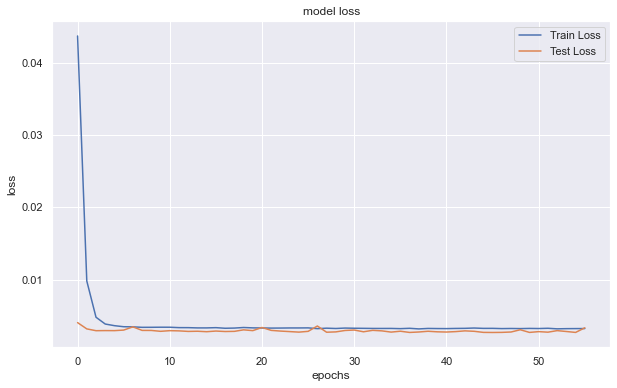

In [70]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stop])

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [71]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_dataset_like = np.zeros(shape=(len(trainPredict), 4))
trainPredict_dataset_like[:,0] = trainPredict[:,0]
testPredict_dataset_like = np.zeros(shape=(len(testPredict), 4))
testPredict_dataset_like[:,0] = testPredict[:,0]

trainPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
testPredict = scaler.inverse_transform(testPredict_dataset_like)[:,0]

trainY_dataset_like = np.zeros(shape=(len(trainY), 4))
trainY_dataset_like[:,0] = trainY
testY_dataset_like = np.zeros(shape=(len(testY), 4))
testY_dataset_like[:,0] = testY

trainY = scaler.inverse_transform(trainY_dataset_like)[:,0]
testY = scaler.inverse_transform(testY_dataset_like)[:,0]

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

6/6 [==============================] - 0s 1ms/step
Train Score: 0.55 RMSE
Test Score: 0.52 RMSE


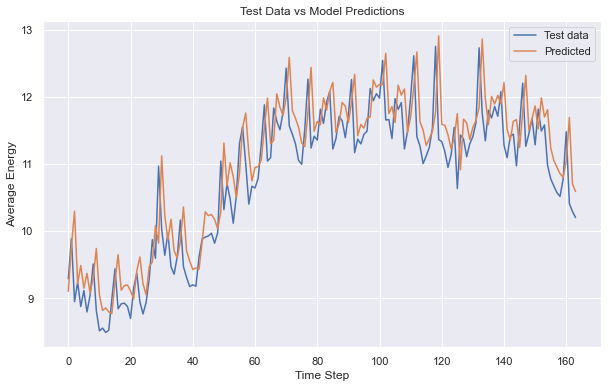

In [73]:
plt.figure(figsize=(10,6))
plt.plot(testY, label='Test data')
plt.plot(testPredict, label='Predicted')
plt.title('Test Data vs Model Predictions')
plt.xlabel('Time Step')
plt.ylabel('Average Energy')
plt.legend()
plt.show();